In [272]:
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib 
import scipy 
import sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from math import sqrt



In [203]:
print(xgboost.__version__)

1.6.2


In [204]:
from xgboost import XGBRegressor
model = XGBRegressor()


In [205]:
#Dataset
df = pd.read_csv('/Users/paul.carroll/Github/Forecasting/data/weather.csv')
df['date'] = pd.to_datetime(df[['Day','Month','Year']])
df.set_index('date',inplace=True, drop=True)

df.head(2)



,Year,Month,Day,Hour,Minute,Temperature daily mean [2 m above gnd],Relative Humidity daily mean [2 m above gnd],Mean Sea Level Pressure daily mean [MSL],Total Precipitation (low resolution) daily sum [sfc],Total Cloud Cover daily mean [sfc],...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],Wind Speed daily max [900 mb],Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-01,2000,1,1,0,0,26.98,61.46,1006.71,2.1,69.88,...,100.0,0.0,5.13,0.08,7.88,0.17,18.62,1.00,12.30,4.03
2000-01-02,2000,1,2,0,0,24.44,82.12,1007.59,6.7,69.92,...,100.0,0.0,4.31,1.62,6.59,2.29,17.01,4.82,13.42,4.47


In [206]:
rename_map = {
   
    'Total Precipitation (low resolution) daily sum [sfc]':    'Rainfall',
    'Total Cloud Cover daily mean [sfc]':'Cloudcover',
   'Sunshine Duration daily sum [sfc]': 'Sunshine',
    'Temperature daily mean [2 m above gnd]':'Temperature',
    'Temperature daily max [2 m above gnd]':'Temperature_max',
    'Relative Humidity daily mean [2 m above gnd]':'Humidity',
    'Mean Sea Level Pressure daily mean [MSL]':'Pressure_mean',
    'Shortwave Radiation daily sum [sfc]':'Radiation',
     'Wind Speed daily max [900 mb]':'max_wind_speed',
    'Wind Speed daily mean [900 mb]':'Windspeed_mean'
}

df.rename(columns=rename_map, inplace=True)

In [211]:
dfU = df.iloc[0:,5:6]
dfU.head(2)

,Temperature
date,
2000-01-01,26.98
2000-01-02,24.44


In [433]:
# turn the univariate series into a sliding window. 

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()

    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [434]:
#split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test, :], data[-n_test:, :]

In [435]:
from numpy import asarray
def xgboost_forecast(train, testX):
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, max_depth = 6)
    model.fit(trainX, trainy)
    yhat = model.predict(asarray([testX]))
    return yhat[0]

In [436]:
# walk-forward validation for univariate data
def walk_forward(data, n_test):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]

    for i in range(len(test)):
        x_test, y_test = test[i, :-1], test[i, 0]
        yhat = xgboost_forecast(history, x_test)
        predictions.append(yhat)
        history.append(test[i])
        print('>expected=%.1f, predicted=%.1f' % (y_test, yhat))
#Input: %s, 
    mae = mean_absolute_error(test[:, -1], predictions)
    rmse = sqrt(mean_squared_error(test[:,-1],predictions))
    
    return mae, rmse,test[:, -1], predictions

>expected=24.8, predicted=26.0
>expected=24.6, predicted=23.9
>expected=24.4, predicted=25.2
>expected=24.4, predicted=23.9
>expected=24.8, predicted=25.0
>expected=23.4, predicted=24.0
MAE: 0.996
RMSE: 0.898


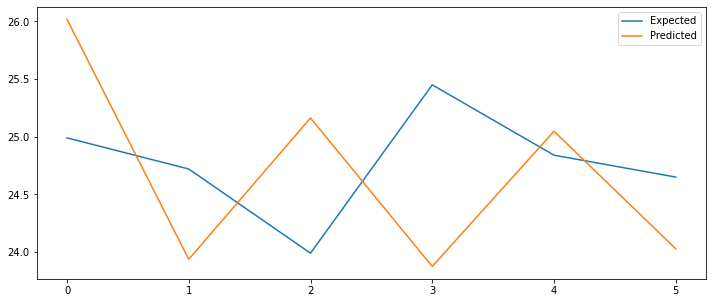

In [437]:
#set input range
data = series_to_supervised(dfU, n_in=18)

rmse,mae, y, yhat = walk_forward(data, 6)
print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show();


Now for XGBoost on a multivariate time series

In [404]:
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV


In [405]:
dfm = df.resample('M').mean()

In [408]:
dfm.head(1)

,Year,Month,Day,Hour,Minute,Temperature,Humidity,Pressure_mean,Rainfall,Cloudcover,...,Low Cloud Cover daily max [low cld lay],Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],max_wind_speed,Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc]
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,2000.0,1.0,16.0,0.0,0.0,25.587742,73.243226,1008.476129,5.270968,66.566452,...,88.322581,0.0,5.197097,1.433548,7.170645,2.61,17.319032,6.57,12.534194,4.885806


In [358]:
def split_data(data, test_split):
        l = len(data)
        t_idx = round(l*(1-test_split))
        train, test = data[ : t_idx], data[t_idx : ]
        print(f'train: {len(train)} , test: {len(test)}')
        return train, test

In [389]:
#set column name for prediction variable
z = 'Temperature'

In [390]:
q = (int(len(dfm)/6)*5)
prediction_set = dfm[q:]
len(prediction_set)

40

In [391]:
prediction_set = prediction_set.drop(z, axis= 1)

In [365]:
dfm2 = dfm[:q]
predictors = dfm2.drop(z,axis=1)

In [492]:
X = predictors.iloc[:,1: -1].values
y = dfm2[z].values

In [493]:
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state= 0, shuffle=False)

In [495]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_trains = pd.DataFrame(scaler.fit_transform(X_train))
X_tests = pd.DataFrame(scaler.transform(X_test))
                        

In [497]:
from xgboost import plot_importance, plot_tree
params = {'max_depth':range(1,6,2), 'min_child_weight':range(1,10,2), 'n_estimators':[100,1000,10000],'learning_rate':[0.01,0.1]}

modelXGB = XGBRegressor(objective = 'reg:squarederror')
#cv = TimeSeriesSplit(n_splits=10).split(X_trains)
gs = GridSearchCV(estimator=modelXGB, cv=10,
                        param_grid=params)
gs.fit(X_trains, y_train)
print(gs.best_estimator_)


'''
modelXGB.fit(X_trains, y_train)
'''

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=1, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)


'\nmodelXGB.fit(X_trains, y_train)\n'

In [498]:
preds_xgb = gs.predict(X_tests)

mae_xgb = mean_absolute_error(y_test, preds_xgb)
rmse_xgb = sqrt(mean_squared_error(y_test, preds_xgb))

print('MAE: %.3f' % mae)
print('RMSE: %.3f' % rmse_xgb)


MAE: 0.996
RMSE: 0.231


In [499]:
X_pred = prediction_set.iloc[:,1:-1].values
X_pred_s = StandardScaler().fit_transform(X_pred)

In [502]:
predictions = gs.predict(X_pred_s)
predictions = pd.DataFrame({'Predictions': predictions})

In [503]:
results = pd.concat([prediction_set.tail(len(X_pred_s)).reset_index(drop=True),predictions],axis=1)

In [504]:
results['date'] = pd.to_datetime(results[['Day','Month','Year']])
results.set_index('date',inplace=True, drop=True)

In [505]:
results.head(2)

,Year,Month,Day,Hour,Minute,Humidity,Pressure_mean,Rainfall,Cloudcover,High Cloud Cover daily mean [high cld lay],...,Low Cloud Cover daily min [low cld lay],Wind Speed daily max [10 m above gnd],Wind Speed daily min [10 m above gnd],Wind Speed daily max [80 m above gnd],Wind Speed daily min [80 m above gnd],max_wind_speed,Wind Speed daily min [900 mb],Wind Gust daily max [sfc],Wind Gust daily min [sfc],Predictions
date,,,,,,,,,,,,,,,,,,,,,
2016-09-15,2016.0,9.0,15.5,0.0,0.0,63.76700,1013.710667,0.626667,41.150667,28.34800,...,3.333333,6.063000,1.369000,8.773333,2.248333,16.469667,3.319000,9.708333,2.453,26.80946
2016-10-16,2016.0,10.0,16.0,0.0,0.0,75.04129,1010.992581,4.561290,64.670968,52.63871,...,3.225806,6.154194,1.051935,8.485484,2.063226,18.180000,4.680645,10.203548,3.240,25.85952


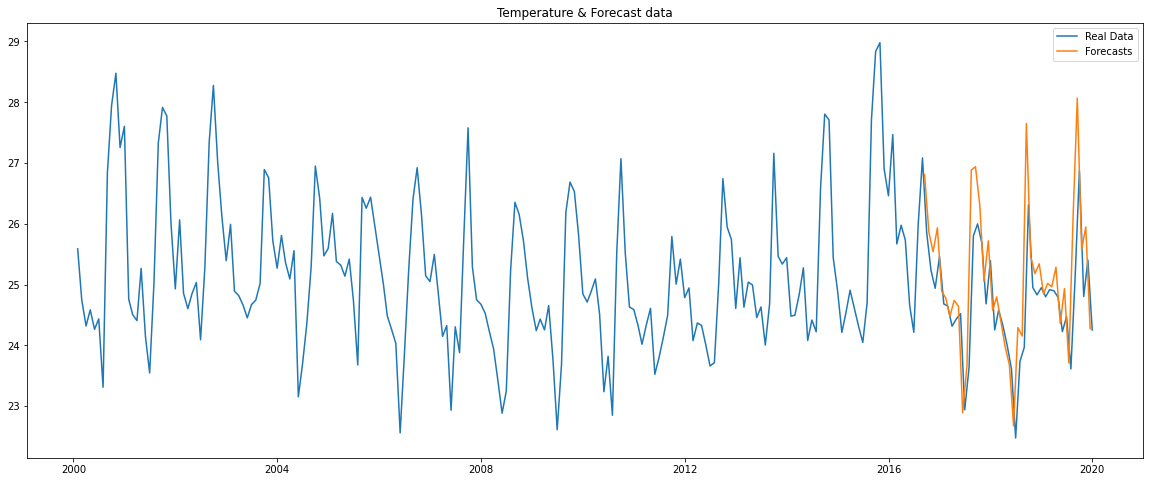

In [506]:
plt.figure(figsize=(20,8))
plt.plot(dfm.Temperature, label = 'Real Data')
plt.plot(results.Predictions, label = 'Forecasts')
plt.legend()
plt.title('Temperature & Forecast data')
plt.show();

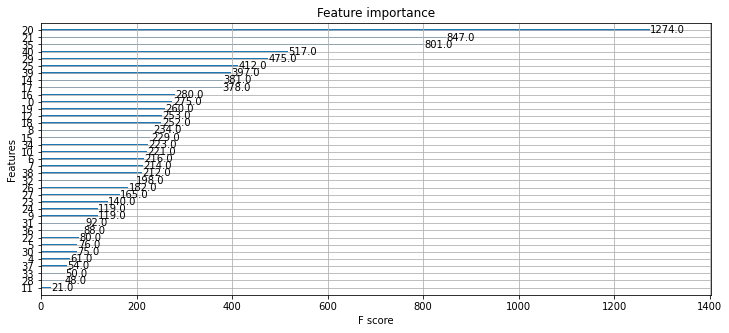

In [510]:
# Visualise the feature importance
plot_importance(gs.best_estimator_);

Some other options to consider with univariate and multivariate XGBoost, TimeSeriesSplit in sklearn.
additionally a gridsearch parameter search
tscv = TimeSeriesSplit()
print(tscv)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
model = XGBRegressor()
params = {'max_depth':range(1,10,2), 'min_child_weight':range(1,10,2), 'n_estimators':[100,1000,10000],'learning_rate':[0.01,0.1]}
from xgboost import plot_importance, plot_tree

X = np.array(predictors)
y = np.array(dfm.Temperature)
tscv = TimeSeriesSplit(n_splits=2)
model = xgb.XGBRegressor()
param_search = params
#{'max_depth':range(3,5)}
my_cv = TimeSeriesSplit(n_splits=5).split(X)
gsearch = GridSearchCV(estimator=model, cv=my_cv,
                        param_grid=param_search)
gsearch.fit(X, y)
print(gsearch.best_estimator_)
print(gsearch.score(X,y))
